In [ ]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm

from utils import get_dls, evaluate

In [ ]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

# tensorflow RNG
# tf.random.set_seed(seed)

In [3]:
path = Path("/mnt/nas/backups/08-07-2020/desktopg01/lisa/Data/small_flow")

In [4]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=GrandparentSplitter(valid_name="val"),
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75,
                                               do_flip=False, max_rotate=0,
                                               max_warp=0
                                               ),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [5]:
dls = get_dls(path, 64, 224)

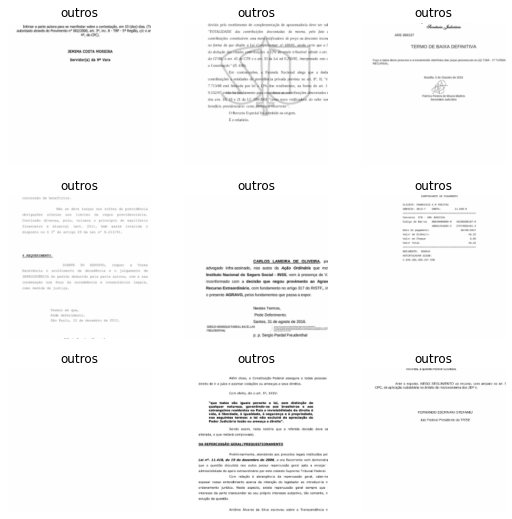

In [6]:
dls.show_batch()

In [7]:
fscore = F1Score(average='macro')

In [15]:
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, fscore])

In [12]:
learn.freeze()

In [ ]:
learn.summary()

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.03981071710586548)

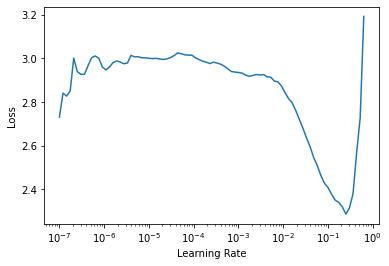

In [11]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 2e-2)

In [14]:
learn.save("resnet50-fine-tuned-1E-224")

Path('models/resnet50-fine-tuned-1E-224.pth')

In [16]:
learn.load("resnet50-fine-tuned-1E-224")

In [28]:
evaluate(learn, dls)

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       314
agravo_em_recurso_extraordinario     1.0000    0.0004    0.0008      2650
     despacho_de_admissibilidade     0.0000    0.0000    0.0000       183
                          outros     0.8884    0.9999    0.9408     91434
                   peticao_do_RE     0.0000    0.0000    0.0000      6803
                        sentenca     0.9506    0.0477    0.0909      1613

                        accuracy                         0.8884    102997
                       macro avg     0.4732    0.1747    0.1721    102997
                    weighted avg     0.8293    0.8884    0.8367    102997



/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
learn.unfreeze()
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    4,096      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     True      
_________________________________________________

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=5.754399353463668e-06)

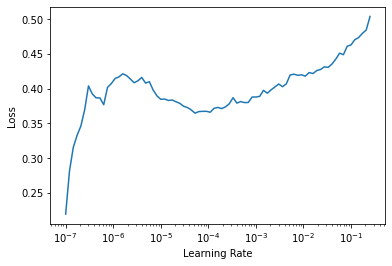

In [16]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(3, lr_max=slice(2e-6,2e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.376510,0.398590,0.888948,0.888948,2:55:02
1,0.348020,0.373706,0.889346,0.889346,2:56:31
2,0.336506,0.391261,0.891278,0.891278,2:56:27


In [19]:
learn.save("resnet50-fine-tuned-1E-disc-3E-224")

Path('models/resnet50-fine-tuned-1E-disc-3E-224.pth')

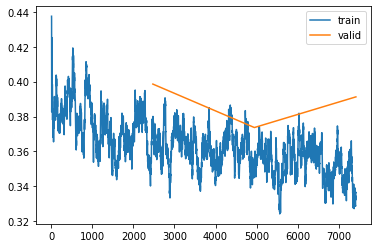

In [21]:
learn.recorder.plot_loss()

In [24]:
evaluate(learn, dls)

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       314
agravo_em_recurso_extraordinario     0.0000    0.0000    0.0000      2650
     despacho_de_admissibilidade     0.0000    0.0000    0.0000       183
                          outros     0.8918    0.9990    0.9423     91434
                   peticao_do_RE     0.7820    0.0548    0.1025      6803
                        sentenca     0.9540    0.0515    0.0976      1613

                        accuracy                         0.8913    102997
                       macro avg     0.4380    0.1842    0.1904    102997
                    weighted avg     0.8582    0.8913    0.8448    102997



/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
evaluate(learn, dls, 0)

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       583
agravo_em_recurso_extraordinario     0.0000    0.0000    0.0000      4220
     despacho_de_admissibilidade     0.0000    0.0000    0.0000       361
                          outros     0.8992    0.9968    0.9455    140786
                   peticao_do_RE     0.8277    0.1137    0.2000     10181
                        sentenca     0.7186    0.2627    0.3848      2177

                        accuracy                         0.8974    158308
                       macro avg     0.4076    0.2289    0.2550    158308
                    weighted avg     0.8628    0.8974    0.8590    158308



In [10]:
n_samples = len(dls.train_ds); n_samples

158308

In [45]:
class_counts = np.array([len((path/"train"/c).ls()) for c in dls.vocab]); class_counts

array([   583,   4220,    361, 140786,  10181,   2177])

In [48]:
class_weights = n_samples / (dls.c * class_counts); class_weights

array([45.25671812,  6.25229068, 73.0877193 ,  0.18740973,  2.59155944,
       12.11973664])

In [49]:
class_weights = torch.FloatTensor(class_weights).cuda()

In [50]:
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(weight=class_weights), metrics=[accuracy, fscore])

In [51]:
learn.freeze()

In [52]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    4,096      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     False     
_________________________________________________

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=7.585775847473997e-07)

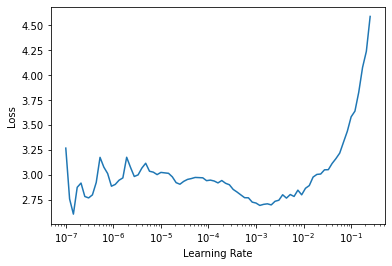

In [53]:
learn.lr_find()

In [54]:
learn.fit_one_cycle(1, 2e-4)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.401020,1.564654,0.325543,0.211959,2:59:33


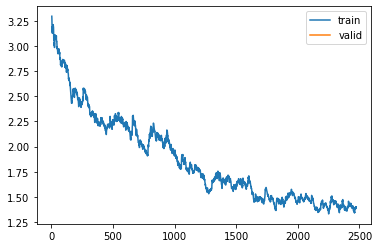

In [55]:
learn.recorder.plot_loss()

In [56]:
learn.save("resnet50-fine-tuned-1E-224_class_weights")

Path('models/resnet50-fine-tuned-1E-224_class_weights.pth')

In [16]:
learn.load("resnet50-fine-tuned-1E-224_class_weights")

In [59]:
evaluate(learn, dls)

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0516    0.5796    0.0947       314
agravo_em_recurso_extraordinario     0.0425    0.7264    0.0803      2650
     despacho_de_admissibilidade     0.0165    0.5574    0.0320       183
                          outros     0.9812    0.2986    0.4578     91434
                   peticao_do_RE     0.1899    0.4492    0.2669      6803
                        sentenca     0.2375    0.5983    0.3400      1613

                        accuracy                         0.3255    102997
                       macro avg     0.2532    0.5349    0.2120    102997
                    weighted avg     0.8886    0.3255    0.4318    102997



In [60]:
learn.unfreeze()
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    4,096      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     True      
_________________________________________________

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.9054607491852948e-06)

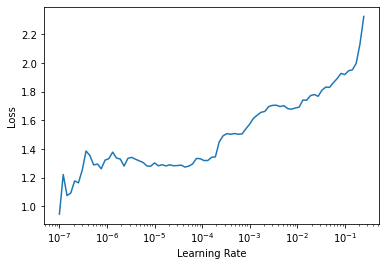

In [61]:
learn.lr_find()

In [62]:
learn.fit_one_cycle(3, lr_max=slice(2e-6,2e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.156742,1.552610,0.335320,0.239621,3:00:55
1,1.175684,1.334942,0.408818,0.275152,3:03:26
2,1.040328,1.336842,0.410925,0.292869,3:02:56


In [63]:
learn.save("resnet50-fine-tuned-1E-disc-3E-224_class_weights")

Path('models/resnet50-fine-tuned-1E-disc-3E-224_class_weights.pth')

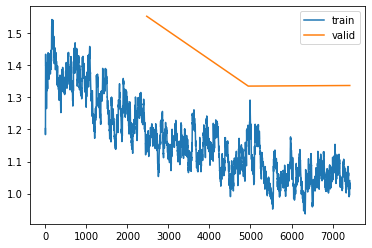

In [64]:
learn.recorder.plot_loss()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=1.0964781722577754e-06)

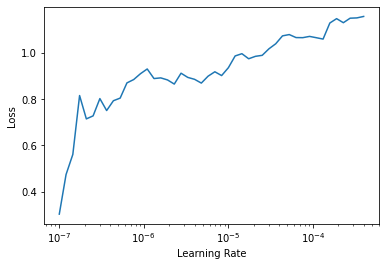

In [65]:
learn.lr_find()

In [66]:
learn.fit_one_cycle(3, lr_max=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.007103,1.338495,0.407808,0.293773,3:00:14
1,1.024088,1.177472,0.475897,0.282301,2:59:24
2,0.975245,1.221048,0.454547,0.300860,3:00:23


In [67]:
learn.save("resnet50-fine-tuned-1E-disc-6E-224_class_weights")

Path('models/resnet50-fine-tuned-1E-disc-6E-224_class_weights.pth')

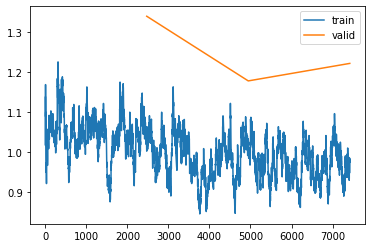

In [68]:
learn.recorder.plot_loss()

In [71]:
evaluate(learn, dls)

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.1163    0.6975    0.1994       314
agravo_em_recurso_extraordinario     0.0531    0.7826    0.0994      2650
     despacho_de_admissibilidade     0.0320    0.6721    0.0611       183
                          outros     0.9797    0.4353    0.6028     91434
                   peticao_do_RE     0.2347    0.5281    0.3250      6803
                        sentenca     0.4422    0.6237    0.5175      1613

                        accuracy                         0.4545    102997
                       macro avg     0.3097    0.6232    0.3009    102997
                    weighted avg     0.8939    0.4545    0.5680    102997



In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(1)

In [ ]:
interp.plot_confusion_matrix(figsize=(7,7))